## Import the Required Data and Libraries

In [1]:
%pip install matplotlib
%pip install matplotlib-inline
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import DBScan as db

In [32]:
import os
import warnings

## Perform Exploratory Data Analysis

In [4]:
DATA_DIRECTORY = "../data"
RAW_DATA_FILE = f"{DATA_DIRECTORY}/database_raw.csv"

assert os.path.isdir(DATA_DIRECTORY)
assert os.path.isfile(RAW_DATA_FILE)

In [5]:
raw_df = pd.read_csv(RAW_DATA_FILE)

In [6]:
dates_df = raw_df[~raw_df["Time"].str.endswith("Z")].copy()
dates_df["Date"] = pd.to_datetime(dates_df["Date"])
dates_df.sort_values(by="Date", inplace=True)
dates_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [7]:
earliest_yr = dates_df.iloc[0, 0].year
latest_yr = dates_df.iloc[-1, 0].year
print(f"The earliest year in the dataset is {earliest_yr}")
print(f"The latest year in the dataset is {latest_yr}")

The earliest year in the dataset is 1965
The latest year in the dataset is 2016


##### Our insight from this visualization is that this dataset contains mostly recent earthquakes, making it more relevant for our problem

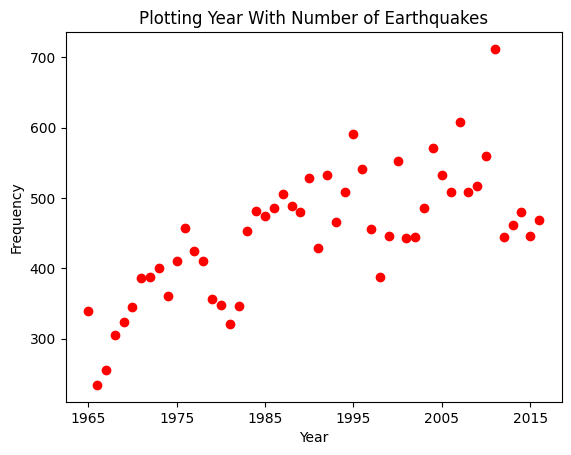

In [8]:
years = [yr for yr in range(1965, 2016+1)]
year_frequencies = [0 for _ in range(len(years))]

for date in dates_df["Date"]:
    yr = date.year
    year_frequencies[yr-1965] += 1

plt.title("Plotting Year With Number of Earthquakes")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks([years[i] for i in range(len(years)) if i % 10 == 0])
plt.scatter(years, year_frequencies, color="red")
plt.show()

#### Explore the different types in this dataset

Our conclusion from this is that there is an insufficient amount of tuples with explosions to make any meaningful analysis. There are precisely 4 such tuples. Therefore, this attribute should be removed.

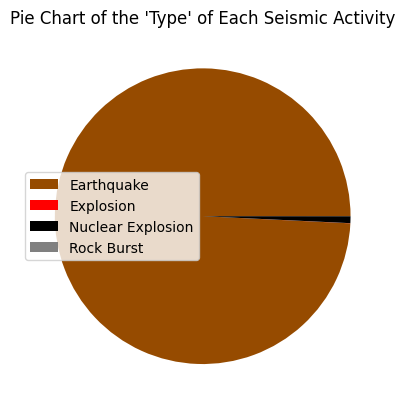

In [9]:
types = list(np.unique(raw_df["Type"].values))
type_frequencies = [0 for _ in range(len(types))]
type_hash = dict()

for i, tp in enumerate(types):
    type_hash[tp] = i

for tp in raw_df["Type"].values:
    type_frequencies[type_hash[tp]] += 1

plt.title("Pie Chart of the 'Type' of Each Seismic Activity")
plt.pie(type_frequencies,
        colors=['#964B00', 'red', "black", "gray"])
plt.legend(labels=types)
plt.show()

#### Explore the different magnitude types in this dataset

Our conclusion from this is that there are various types of magnitude types that are represented in sizable proportions, which could be useful for further analysis.

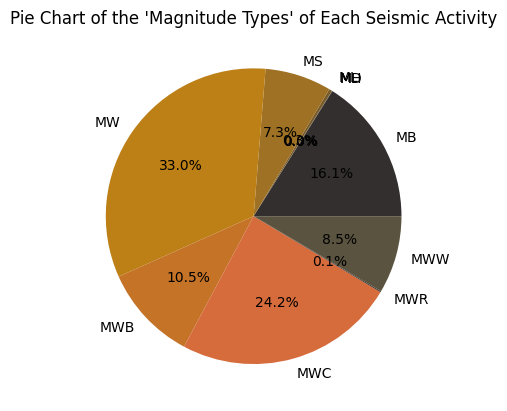

In [10]:
mag_types = list(np.unique(raw_df["Magnitude Type"].dropna().apply(str).values))
mag_type_frequencies = [0 for _ in range(len(mag_types))]
mag_type_hash = dict()

for i, tp in enumerate(mag_types):
    mag_type_hash[tp] = i

for tp in raw_df["Magnitude Type"].values:
    if tp not in mag_types:
        continue
    mag_type_frequencies[mag_type_hash[tp]] += 1

plt.title("Pie Chart of the 'Magnitude Types' of Each Seismic Activity")
plt.pie(mag_type_frequencies,
        labels=mag_types,
        autopct='%1.1f%%',
        colors=["#332F2E", "#59533F", "#473D2C", "#785B2A", "#9E7124", "#BD8017", "#C47327", "#D66B3C"])
plt.show()

## Data Pre-Processing

#### Feature Selection (Removal)
- `Time`: Not terribly relevant for clustering and outlier detection
- `Type`: Too much data imbalance for the classes
- `ID`: Completely irrelevant in earthquake analysis
- `Source`: We are assuming the sources are reliable
- `Depth Error`, `Depth Seismic Stations`, `Magnitude Error`, `Magnitude Seismic Stations`, `Azimuthal Gap`, `Horizontal Distance`, `Horizontal Error`, `Location Source`, `Magnitude Source`, `Status`: Significant portion of values are missing and/or feature is not relevant to our problem.

In [11]:
df = raw_df.copy()

df = df[df["Type"] == "Earthquake"]

df = df.drop(['Depth Error','Depth Seismic Stations','Magnitude Error', 'Magnitude Seismic Stations','Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'Location Source', 'Magnitude Source', 'Status', 'ID', 'Source', 'Type'], axis=1)

df = df[~df["Date"].str.endswith("Z")]
df = df[~df["Time"].str.endswith("Z")]

DATA_FILE = f"{DATA_DIRECTORY}/earthquakes.csv"
df.to_csv(DATA_FILE, index=False)

#### Feature Creation
- `Country`: The country that this earthquake ("International Waters if not belonging to a country")
- `Ocean`: The ocean that the location sits on (`np.nan` if on land)

## Perform DBScan

In [13]:
epsilon = 350
minSamp = 5
DBSCAN_OUTPUT_FILE = f"{DATA_DIRECTORY}dbscan_out.csv"
df['Cluster'] = db.DBScan(DATA_FILE, epsilon, minSamp, DBSCAN_OUTPUT_FILE)

Looking for cluster 1...
Cluster 1 complete. Looking for cluster 2...
Cluster 2 complete. Looking for cluster 3...
Cluster 3 complete. Looking for cluster 4...
Cluster 4 complete. Looking for cluster 5...
Cluster 5 complete. Looking for cluster 6...
Cluster 6 complete. Looking for cluster 7...
Cluster 7 complete. Looking for cluster 8...
Cluster 8 complete. Looking for cluster 9...
Cluster 9 complete. Looking for cluster 10...
Cluster 10 complete. Looking for cluster 11...
Cluster 11 complete. Looking for cluster 12...
Cluster 12 complete. Looking for cluster 13...
Cluster 13 complete. Looking for cluster 14...
Cluster 14 complete. Looking for cluster 15...
Cluster 15 complete. Looking for cluster 16...
Cluster 16 complete. Looking for cluster 17...
Cluster 17 complete. Looking for cluster 18...
Cluster 18 complete. Looking for cluster 19...
Cluster 19 complete. Looking for cluster 20...
Cluster 20 complete. Looking for cluster 21...
Cluster 21 complete. Looking for cluster 22...
Clust

0        1
1        1
2        1
3        1
4        1
        ..
23224    1
23225    1
23226    1
23227    1
23228    3
Name: Cluster, Length: 23229, dtype: int64

## Load DBScan Data, Fault Line Data, and World Map

In [35]:
if 'Cluster' not in df.columns:
    df['Cluster'] = pd.read_csv(DBSCAN_OUTPUT_FILE)['Cluster']

for cid, group in df.groupby('Cluster'):
    if(cid == -1): continue
    print(f"Cluster {cid}: {len(group)} events")

warnings.filterwarnings("ignore", category=UserWarning)
GEM_GAF_DB = gpd.read_file("../data/fault_lines.geojson")

#GEM_GAF_DB = GEM_GAF_DB.to_crs(epsg=3857)

GEM_GAF_DB['plot_lon'] = GEM_GAF_DB.geometry.centroid.x
GEM_GAF_DB['plot_lat'] = GEM_GAF_DB.geometry.centroid.y

world = gpd.read_file(f"{DATA_DIRECTORY}/worldmap_database/ne_110m_admin_0_countries.dbf")

Cluster 1.0: 17015 events
Cluster 2.0: 221 events
Cluster 3.0: 3389 events
Cluster 4.0: 264 events
Cluster 5.0: 42 events
Cluster 6.0: 24 events
Cluster 7.0: 117 events
Cluster 8.0: 94 events
Cluster 9.0: 435 events
Cluster 10.0: 7 events
Cluster 11.0: 82 events
Cluster 12.0: 891 events
Cluster 13.0: 48 events
Cluster 14.0: 24 events
Cluster 15.0: 30 events
Cluster 16.0: 16 events
Cluster 17.0: 10 events
Cluster 18.0: 13 events
Cluster 19.0: 16 events
Cluster 20.0: 26 events
Cluster 21.0: 13 events
Cluster 22.0: 16 events
Cluster 23.0: 6 events
Cluster 24.0: 14 events
Cluster 25.0: 6 events
Cluster 26.0: 6 events
Cluster 27.0: 7 events
Cluster 28.0: 5 events
Cluster 29.0: 5 events
Cluster 30.0: 9 events
Cluster 31.0: 5 events
Cluster 32.0: 5 events


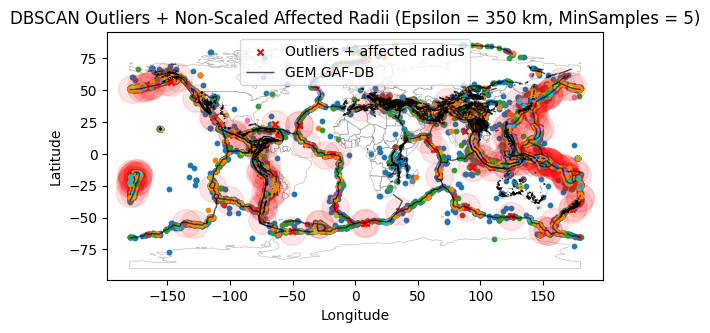



num_outliers: 185

Outlier Average Magnitude = 5.9232432432432445
Outlier Median Magnitude = 5.8



In [34]:
world.boundary.plot(ax=plt.gca(), color='gray', linewidth=0.5, alpha=0.5)

clusters = df['Cluster'].unique()
for id in clusters:
    points = df[df['Cluster'] == id]
    # outliers
    if id == -1:
        plt.scatter(points["Longitude"], points["Latitude"], color='red', marker='o', s=400, alpha=0.1)
        plt.scatter(points["Longitude"], points["Latitude"], color='red', marker='x', s=20, label='Outliers + affected radius' if id==-1 else "")
    # clusters
    else:
        plt.scatter(points["Longitude"], points["Latitude"], s=10)

# geojson overlay
# form lines from centroids ax
GEM_GAF_DB.plot(ax=plt.gca(), color='black', linewidth=1, label='GEM GAF-DB', alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Outliers + Non-Scaled Affected Radii (Epsilon = {epsilon} km, MinSamples = {minSamp})")
plt.legend()
plt.show()

outliers = df[df['Cluster'] == -1]
print("\n")
print(f"num_outliers: {len(outliers)}\n")
print(f"Outlier Average Magnitude = {np.mean(outliers['Magnitude'])}")
print(f"Outlier Median Magnitude = {np.median(outliers['Magnitude'])}\n")